Files needed for this demo:
* tabulated_logE_sindec_aeff_full.pckl
* bckg_flux_vals.pickle
* energy_smearing_kde.pckl

This is a notebook to demonstrate in a 'stand-alone' version how to do a diffuse astrophysical flux fit and LLH ratio test

# Imports

In [129]:
import pickle
import numpy as np
import warnings
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LogNorm
warnings.filterwarnings("ignore")


# Source parameters

In [130]:
# livetime of 10yrs in seconds
LIVETIME = 365 * 10 * 24 * 3600
# Normalization energy of power law (E/E0)^gamma
E0 = 1E5
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
GAMMA = 2.37
PHI_0 = 1.44E-18 # neutrinos * (E/E0)^gamma / GeV / cm^2 / s

# Functions

In [131]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [132]:
def energy_smearing(ematrix, ev):
    """Translate a matrix with axis in true energy to reconstructed energy"""
    return (ematrix @ ev.T).T

In [133]:
def atmo_background(aeff_factor, bckg_flux_vals):
    """Calculate the number of neutrinos of atmospheric background flux as a function reconstructed energy"""
    return energy_smearing(normed_kvals, aeff_factor * bckg_flux_vals)


# Get the effective area

In [149]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)

logE_mids = get_mids(logE_bins)
# cut at E=10⁹GeV
logE_bins = logE_bins[logE_bins<=9]
aeff_2d = aeff_2d["IceCube"][logE_mids<=9]
logE_mids = logE_mids[logE_mids<=9]


ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")


35 log_10(energy) bins
50 declination bins


(2.0, 9.0)

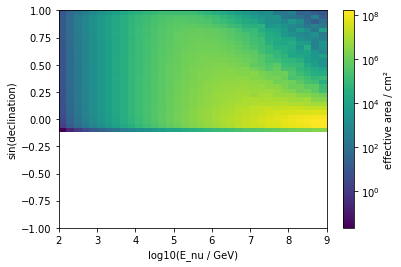

In [150]:
plt.pcolormesh(logE_bins, sindec_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)

# Background

In [151]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
bckg_flux_vals = np.exp(rgi((em, ss))).T

(2.0, 9.0)

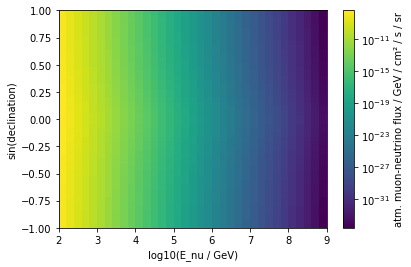

In [152]:
plt.pcolormesh(logE_bins, sindec_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)

# Energy smearing

In [153]:
# energy smearing matrix
with open("../resources/energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.02, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
normed_kvals = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)

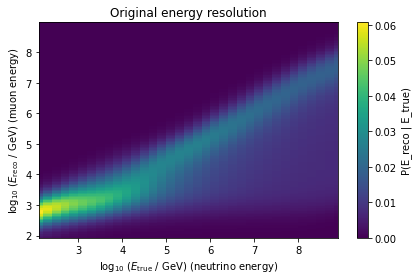

In [154]:
# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

f, axes = plt.subplots()

axes.grid(False)
im = axes.pcolormesh(egrid_true, egrid_reco, normed_kvals)
axes.set_ylim(np.min(egrid_reco), np.max(egrid_reco))
axes.set_xlim(np.min(egrid_true), np.max(egrid_true))
axes.set_title("Original energy resolution")
axes.set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes.set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
cb = f.colorbar(im)
cb.set_label("P(E_reco | E_true)")
f.tight_layout()

# Source flux definition

In [155]:
def astro_flux(
    aeff_factor,
    emids,
    E0,
    gamma,
    phi_scaling,
):
    """
    flux shape: dphi/dE = phi_0 * (E/E0) ** -gamma
    powerlaw parameters:
        * gamma
        * phi scaling (phi normalization will be phi_0 * phi scaling) 
          -> actual fit parameter will be of magnitude 1 instead of E-14
    """
    tmp = aeff_factor * (emids/E0)**(-gamma) * PHI_0 * phi_scaling
    return energy_smearing(normed_kvals, tmp)

In [156]:
# with two dimensions: sindec, energy
def aeff_eval_e_sd(aeff, sindec_width, e_width):
    return (aeff * sindec_width).T * e_width * 2*np.pi

### Full nominal (=Asimov) histograms in  sin(dec) - log(E)

Fit parameters for analysis:
* Global normalization of k_b
* Global normalization of k_s
* Spectral index of k_s (=gamma)

In [157]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d, sindec_width, ewidth) * LIVETIME
)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals)
k_s = astro_flux(
    aeff_factor,
    emids,
    E0,
    GAMMA, ## FIT PARAMETER
    1, ## FIT PARAMETER
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b)) # ~550
print("Signal:", np.sum(k_s)) # ~40
print("S+B", np.sum(k_i)) # ~590




Asimov data sum:
Background: 673312.6074227438
Signal: 2888.920442481476
S+B 676201.5278652253


## some plotting

Text(0.5, 1.0, 'Signal astrophysical flux flux')

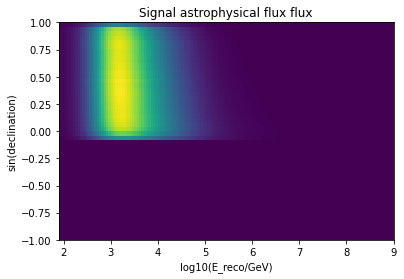

In [158]:
## signal
plt.pcolormesh(logE_reco_bins, sindec_bins, k_s)
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Signal astrophysical flux flux")

Text(0.5, 1.0, 'Background atmospheric flux')

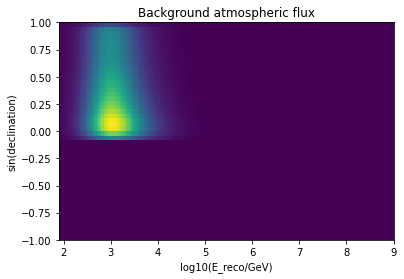

In [159]:
## atmo. background
plt.pcolormesh(logE_reco_bins, sindec_bins, k_b)
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Background atmospheric flux")

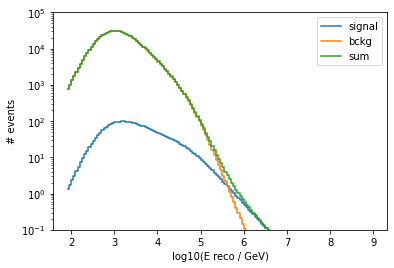

In [160]:
# summed 1D hist in log(E_reco)
plt.plot(logE_reco_mids, k_s.sum(axis=0), ds="steps-mid", label="signal")
plt.plot(logE_reco_mids, k_b.sum(axis=0), ds="steps-mid", label="bckg")
plt.plot(logE_reco_mids, k_i.sum(axis=0), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlabel("log10(E reco / GeV)")
plt.ylabel("# events")
plt.ylim(1E-1, 1E5)
plt.legend()

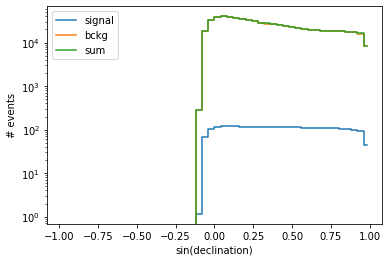

In [161]:
# summed 1D hist in sin(dec)
plt.plot(sindec_mids, k_s.sum(axis=1), ds="steps-mid", label="signal")
plt.plot(sindec_mids, k_b.sum(axis=1), ds="steps-mid", label="bckg")
plt.plot(sindec_mids, k_i.sum(axis=1), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlabel("sin(declination)")
plt.ylabel("# events")
plt.legend()

### DEMO: Significance test Background vs. Background + Signal

In [162]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """

    mu_b = atmo_background(
        mu_b_base, bckg_flux_vals * x[0]
    )
    mu_s = astro_flux(
        mu_s_base, emids, e_0, *x[1:]
    )
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (B/S)
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )
 

In [163]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d, sindec_width, ewidth) * LIVETIME
)

# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 2, 0), aeff_factor, aeff_factor, k_i
)
# background + signal, 3 free parameters
global_llh = lambda x: ps_llh_2d_composite(
    x, aeff_factor, aeff_factor, k_i
)
# ... and fit both hypotheses!
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Bckg-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

# calculate p-value and significance with Wilks' and 2 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


Bckg-only normalization: [1.0042906]
Signal fit parameters: [0.99999943 2.3700677  1.00002791]
P-VALUE: 2.4755945656516476e-12 SIGNIFICANCE: 7.004676292334277
